### Comparing Models and Vectorization Strategies for Text Classification

This try-it focuses on weighing the positives and negatives of different estimators and vectorization strategies for a text classification problem.  In order to consider each of these components, you should make use of the `Pipeline` and `GridSearchCV` objects in scikitlearn to try different combinations of vectorizers with different estimators.  For each of these, you also want to use the `.cv_results_` to examine the time for the estimator to fit the data.

### The Data

The dataset below is from [kaggle](https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection) and contains a dataset named the "ColBert Dataset" created for this [paper](https://arxiv.org/pdf/2004.12765.pdf).  You are to use the text column to classify whether or not the text was humorous.  It is loaded and displayed below.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import wordcloud
import ssl

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, \
                            f1_score
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
# by-pass CERTIFICATE_VERIFY
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [4]:
%%time
nltk.download('wordnet')
nltk.download('omw-1.4')
#nltk.download('punkt')

CPU times: user 68.3 ms, sys: 17.9 ms, total: 86.2 ms
Wall time: 744 ms


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aerdenizmenli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aerdenizmenli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
df = pd.read_csv('text_data/dataset.csv.zip', compression='zip')

In [6]:
df.head()

text  humor
0             Joe biden rules out 2020 bid: 'guys, i'm not running'  False
1               Watch: darvish gave hitter whiplash with slow pitch  False
2                What do you call a turtle without its shell? dead.   True
3                     5 reasons the 2016 election feels so personal  False
4  Pasco police shot mexican migrant from behind, new autopsy shows  False

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [8]:
df.describe()

text   humor
count                                                  200000  200000
unique                                                 200000       2
top     Joe biden rules out 2020 bid: 'guys, i'm not running'   False
freq                                                        1  100000

In [9]:
# no duplicates!
len(df.drop_duplicates())

200000

# Data Preperation by Lemmatizer and Stemmer
 - Expanding contractions: We replaced all contractions with the expanded version of the expressions. For example, ”is not” instead of “isn’t”. 
 - Cleaning punctuation marks: We separated the punctuation marks6 from words to achieve cleaner sentences. For example, the sentence “This is’ (fun).” is converted to “This is ‘ ( fun ) .” 
 - Cleaning special characters: We replaced some special characters with an alias. For example, “alpha” instead of “α”.

Funtions to stem text and returns lemmatized and/or stemmed text
```
    Arguments
    ---------
    text: str
        string of text to be lemmatized and stemmed
        
    Returns
    -------
    str
       string of lemmatized and stemmed words from text input
```
Try out if stemmer or lemmatizer is better:

stemming is better for this dataset. There is no point to try out both stemmer and lemmatizer since out product is the same as stemmed dataset!

In [10]:
# lemmatize
def lemmatize(text):
    # lemmatizer
    lemma = WordNetLemmatizer()
    # tokenize text
    tokenized_text = word_tokenize(text)
    # lemmatize each word and build a string before returning 
    return ' '.join([lemma.lemmatize(w) for w in tokenized_text])

# stem
def stemmer(text):
    # stemmer
    stemmer = PorterStemmer()
    # tokenize text
    tokenized_text = word_tokenize(text)
    # stem each word and build a string before returning 
    return ' '.join([stemmer.stem(w) for w in tokenized_text])

# stemming slight trimming first
# lemmatize second
def stem_and_lemmatize(text):
    # stemmer
    stemmer = PorterStemmer()
    # lemmatizer
    lemma = WordNetLemmatizer()
    # tokenize text
    tokenized_text = word_tokenize(text)
    # stem and lemmatize each word and build a string before returning 
    return ' '.join([lemma.lemmatize(stemmer.stem(w)) for w in tokenized_text])

In [11]:
#stem_and_lemmatize('The computer did not compute the answers correctly.')

In [12]:
stemmer('Consider both the CountVectorizer and TfidifVectorizer to prepare the text data for your estimator, have it ready.')

'consid both the countvector and tfidifvector to prepar the text data for your estim , have it readi .'

In [13]:
lemmatize('Consider both the CountVectorizer and TfidifVectorizer to prepare the text data for your estimator.')

'Consider both the CountVectorizer and TfidifVectorizer to prepare the text data for your estimator .'

In [14]:
stem_and_lemmatize('Consider both the CountVectorizer and TfidifVectorizer to prepare the text data for your estimator.')

'consid both the countvector and tfidifvector to prepar the text data for your estim .'

## Exploratory Data Analysis

### Visualize text Column for Criteria
Check text to see `ain't`, any special characters

In [15]:
# ain't ? 
df[df['text'].str.contains("ain't")].replace({'text':{"ain't":'have not'} }, regex=True)

text  \
728                        Why does islam marginalize their women? because she have not special, shiite.   
1759                            I have not got much but i can keep dry. which is more than moist people.   
1975                        Why is kim jong un like todays music? they both have not got the same seoul.   
2541                                                Wtf is almond milk almonds have not even got titties   
8955                        Farmer: can i help you, sir? me: this have not my first rodeo, buddy farmer:   
...                                                                                                  ...   
187676                                  My teacher told me to turn in my essay, but i have not no snitch   
189091      Why aren't the italians afraid of the biscuit? because it have not nothing butter biscuit!!!   
190148     Now i have not sayin' she a gold digger, but that hard hat and pickaxe are pretty suspicious.   
198364  If earth was a rented apartment, have not noooo waaaaay we're getting our security deposit back.   
198928                                           Ky jelly for when your cousin just have not feeling it.   

        humor  
728      True  
1759     True  
1975     True  
2541     True  
8955     True  
...       ...  
187676   True  
189091   True  
190148   True  
198364   True  
198928   True  

[92 rows x 2 columns]

In [16]:
#35503 107792
df[df['text'].str.contains("n't") | df['text'].str.contains(r'[^a-zA-z0-9]') ].replace({
    'text':{"won't":'will not', "can't":'can not', "ain't":'have not', "n't":' not', "'ll":" will",
            r'[^a-zA-z0-9]': ' '} }, regex=True)

text  \
0                                           Joe biden rules out 2020 bid   guys  i m not running    
1                                             Watch  darvish gave hitter whiplash with slow pitch   
2                                              What do you call a turtle without its shell  dead    
3                                                   5 reasons the 2016 election feels so personal   
4                                Pasco police shot mexican migrant from behind  new autopsy shows   
...                                                                                           ...   
199995                  Conor maynard seamlessly fits old school r b hits to drake s  controller    
199996                                       How to you make holy water  you boil the hell out it   
199997  How many optometrists does it take to screw in a lightbulb  one    or two  one    or two    
199998                         Mcdonald s will officially kick off all day breakfast on october 6   
199999     An irish man walks on the street and ignores a bar    muahahaha  like that s possible    

        humor  
0       False  
1       False  
2        True  
3       False  
4       False  
...       ...  
199995  False  
199996   True  
199997   True  
199998  False  
199999   True  

[200000 rows x 2 columns]

## Preprocessing Corpus
convert "n't" to " not", "'ll" to " will"

In [17]:
# convert "n't" to " not"
# Remove any punctuation, special characters, numbers, anything is not alpanumerical. Replace those with space.
df = df.replace({ 'text':{"won't":'will not', "can't":'can not', "ain't":'have not', "n't":' not', "'ll":" will",
                          "'m":' am', '"':'', r'[^a-zA-z0-9]': ' '} }, regex=True).copy()

## Visualize Frequent Words

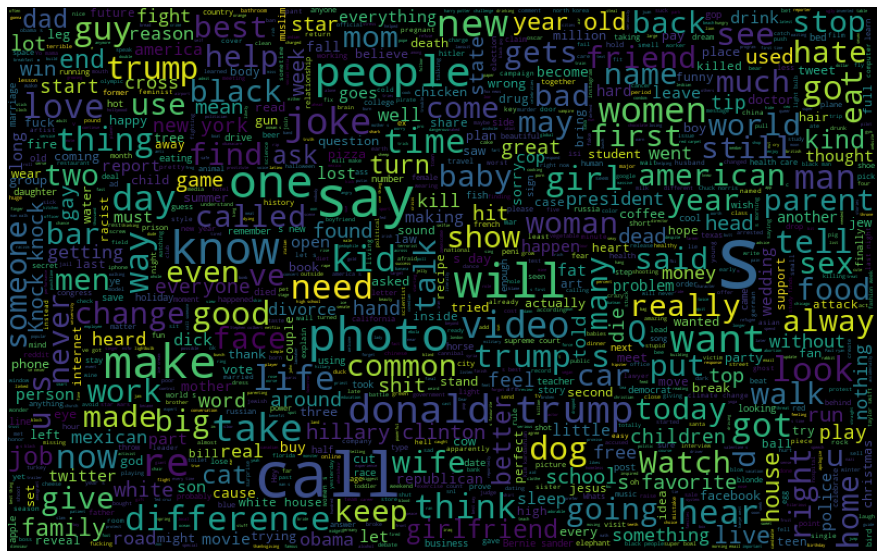

CPU times: user 8.94 s, sys: 498 ms, total: 9.44 s
Wall time: 9.5 s


In [18]:
%%time
plt.subplots(figsize=(16,10))
wc = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=80, max_words=2000,
                      width = 800, height = 500,
                      background_color='black').generate(' '.join(t for t in df['text']))
plt.axis('off')
plt.imshow(wc)
plt.show()

#### Word frequency
Compute word frequency and plot top words

In [19]:
%%time
# Word frequency
stop = stopwords.words('english')
freq = df['text'].str.lower().str.split(expand=True).stack().value_counts().rename_axis('word'). \
    reset_index(name='frequency')

CPU times: user 1.8 s, sys: 95.4 ms, total: 1.9 s
Wall time: 1.9 s


In [20]:
freq = freq[~freq['word'].str.lower().isin(stop)]

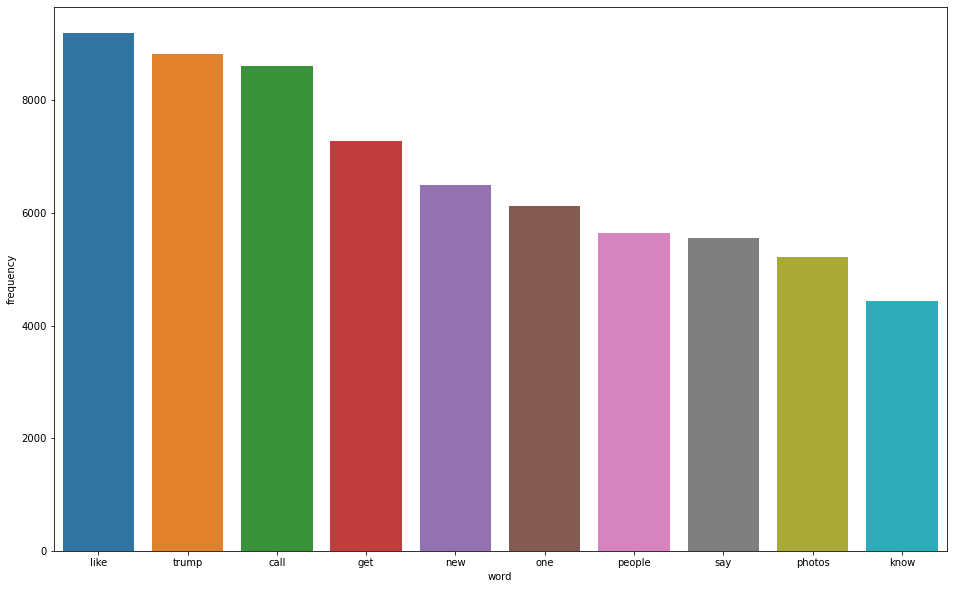

CPU times: user 142 ms, sys: 5.15 ms, total: 147 ms
Wall time: 146 ms


In [21]:
%%time
# Top 10 words
plt.subplots(figsize=(16,10))
sns.barplot(data=freq[0:10], x='word', y='frequency')
plt.show()

### Split normalized dataset

In [22]:
%%time
#processor = lemmatize, stemmer or stem_and_lemmatize
# normalize text
normalized = df.copy()
normalized['text'] = df['text'].apply(stemmer)

# Prepare X and y and split them
X, y = normalized['text'], normalized['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, test_size = 0.25, stratify = y)

CPU times: user 49.2 s, sys: 76 ms, total: 49.2 s
Wall time: 49.3 s


In [23]:
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((200000,), (200000,), (150000,), (50000,), (150000,), (50000,))

In [24]:
# Check if they are balanced!
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(True     0.5
 False    0.5
 Name: humor, dtype: float64,
 False    0.5
 True     0.5
 Name: humor, dtype: float64)

#### Check CountVectorizer and TfidfVectorizer Columns
Execute `CountVectorizer` and `TfidfVectorizer` transformers to see how many columns are outputted.

In [25]:
%%time
# check how many features are produced by the vectorizer, ignore numeric:
cvct = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z]{2,}\b")
ct = cvct.fit_transform(X)
len(cvct.get_feature_names_out())
#pd.DataFrame(ct.toarray(), columns = cvct.get_feature_names_out()).head()

CPU times: user 1.66 s, sys: 19.8 ms, total: 1.68 s
Wall time: 1.68 s


42540

In [26]:
pd.DataFrame(ct.toarray(), columns = cvct.get_feature_names_out()).head(1)
#cvct.get_feature_names_out()

aa  aaa  aaaa  aaaaa  aaaaaaaaaaaaaa  aaaaaaaaand  aaaaaaaah  aaaaaaah  \
0   0    0     0      0               0            0          0         0   

   aaaaaaannd  aaaaaaarrrrrrrrrrrrrrrrrrrr  aaaaaagggccchhhhmmmm  aaaaaah  \
0           0                            0                     0        0   

   aaaaaarrrrrrrrrrrrr  aaaaaayyyyyyyi  aaaaarbi  aaaaarrrrggghhhh  \
0                    0               0         0                 0   

   aaaaarrrrrr  aaaach  aaaah  aaaahh  aaaahhhh  aaahh  aaahhh  aaahhhhhhhh  \
0            0       0      0       0         0      0       0            0   

   aaand  aaargh  aaarrrrrrr  aaarrrrrrrr  aaaurrrraaaaggghh  aaayyy  aad  \
0      0       0           0            0                  0       0    0   

   aadmi  aah  aaliyah  aam  aan  aanav  aang  aanim  aanteat  aap  aapi  \
0      0    0        0    0    0      0     0      0        0    0     0   

   aard  aardvark  aargh  aarhu  aaron  aarp  aarrgh  aasian  aasif  aasm  \
0     0         0      0      0      0     0       0       0      0     0   

   aatish  aau  aayla  ab  abaaoud  abacu  abad  abalon  abandon  abandonnon  \
0       0    0      0   0        0      0     0       0        0           0   

   abas  abaya  abb  abba  abbay  abbey  abbi  abbot  abbotsford  abbott  \
0     0      0    0     0      0      0     0      0           0       0   

   abbottabad  abbrevi  abbvi  abc  abcd  abcdefghijk  abcdefghijklmfao  \
0           0        0      0    0     0            0                 0   

   abcdefghijklmnopq  abcdefghijklmnopqrstuvwxyz  abcreport  abdel  \
0                  0                           0          0      0   

   abdelhamid  abdella  abdeslam  abdi  abdic  abdomin  abdrazakova  abduct  \
0           0        0         0     0      0        0            0       0   

   abducte  abductor  abdul  abdulaziz  abe  abedi  abedin  abel  abelian  \
0        0         0      0          0    0      0       0     0        0   

   abercrombi  aberdeen  abet  abff  abhor  abid  abiden  abigail  abil  abl  \
0           0         0     0     0      0     0       0        0     0    0   

   ablaz  abli  ablow  abmb  abner  abney  abnorm  aboard  abod  abola  \
0      0     0      0     0      0      0       0       0     0      0   

   abolish  abolit  abolitionist  abombinabul  abomin  aboot  abori  aborigin  \
0        0       0             0            0       0      0      0         0   

   aborscht  abort  abortionist  abortu  abou  abound  about  aboutaleb  abov  \
0         0      0            0       0     0       0      0          0     0   

   abra  abracadabra  abracadav  abradacobra  abraham  abram  abramov  \
0     0            0          0            0        0      0        0   

   abramovi  abramowski  abramson  abraxan  abreast  abridg  abroad  abroc  \
0         0           0         0        0        0       0       0      0   

   abruc  abrupt  abruptli  abruzzo  abscond  abseil  absenc  absent  absente  \
0      0       0         0        0        0       0       0       0        0   

   absinth  absolut  absolv  absorb  absorpt  abstain  abstin  abstract  \
0        0        0       0       0        0        0       0         0   

   absurd  absurdist  absurdistan  absurdli  abt  abu  abuela  abuelita  \
0       0          0            0         0    0    0       0         0   

   abund  aburrido  abus  abut  abutilon  abysm  abyss  abyssinia  ac  aca  \
0      0         0     0     0         0      0      0          0   0    0   

   acadamia  academ  academi  academia  acai  acapella  acappellago  acc  \
0         0       0        0         0     0         0            0    0   

   acceler  acceleraptor  accent  accentu  accentur  accept  access  accessor  \
0        0             0       0        0         0       0       0         0   

   accessori  acci  accid  accident  accidentali  accidenti  accino  accio  \
0          0     0      0         0            0      

In [27]:
%%time
# check how many features are produced by the vectorizer, ignore numeric:
tvct = TfidfVectorizer(token_pattern = r"(?u)\b[a-zA-Z]{2,}\b")
tt = tvct.fit_transform(X)
len(tvct.get_feature_names_out())
#pd.DataFrame(tt.toarray(), columns = tvct.get_feature_names_out()).head()

CPU times: user 1.84 s, sys: 29.1 ms, total: 1.87 s
Wall time: 1.87 s


42540

#### Task

- **TEXT PREPROCESSING**: Consider both the `CountVectorizer` and `TfidifVectorizer` to prepare the text data for your estimator.  Prepare options for *stop words* and *max features*.  Also, consider both **stemming** and **lemmatizing** to normalize your text before classifying.

- **CLASSIFICATION**: Consider `LogisticRegression`, `DecisionTreeClassifier`, and `MultinomialNB` as classification algorithms for the data.  Compare their performance in terms of accuracy and speed.

Share the results of your best classifier in the form of a table with the best version of each estimator, a dictionary of the best parameters and the best score.


|model	|best_params	|best_score|
|--|--|--|
|Logistic|	|	|
|Decision Tree|	|	|
|Bayes|	|	|


### Functions

In [28]:
def model_executor(model, vectorizer, parameters):
    # Pipeline
    vect_pipe = Pipeline([
        ('vct', vectorizer),
        ('mdl', model)
    ])
    # model grid search
    model_grid = GridSearchCV(vect_pipe, param_grid=parameters).fit(X_train, y_train)

    # metrics
    model_train = model_grid.score(X_train, y_train)
    model_test  = model_grid.score(X_test, y_test)
    model_time  = np.sum(model_grid.cv_results_['mean_fit_time']) + np.sum(model_grid.cv_results_['mean_score_time'])
    model_score = model_grid.best_score_
    model_params = model_grid.best_params_
    model_results = model_grid.cv_results_

    # results
    print(model, vectorizer)
    print(f'Best Model score : {model_score: .5f}')
    print(f'Training Accuracy: {model_train: .5f}')
    print(f'Test Accuracy    : {model_test: .5f}')
    print(f'Model Fit Time   : {model_time: .5f}')
    print(f'Best parameters {model}: {model_params}')

    # confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, model_grid.predict(X_test), display_labels=['False', 'True'])
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

    return vect_pipe, model_grid, model_train, model_test, model_time, model_score, model_params, model_results

In [29]:
# Hyperparameters
params = {'vct__max_features': [2000, 3000]}

In [30]:
# Vectorizers
cntvct = CountVectorizer()
tfdvct = TfidfVectorizer()

In [31]:
# Models
lgr = LogisticRegression(max_iter=250)
dtr = DecisionTreeClassifier()
mnb = MultinomialNB()

## Grid Search

LogisticRegression(max_iter=250) CountVectorizer()
Best Model score :  0.91822
Training Accuracy:  0.92675
Test Accuracy    :  0.91794
Model Fit Time   :  6.19560
Best parameters LogisticRegression(max_iter=250): {'vct__max_features': 3000}


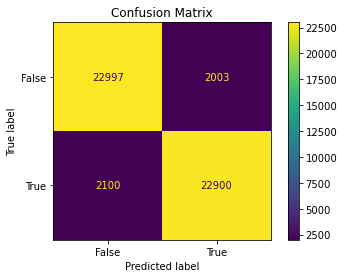

DecisionTreeClassifier() CountVectorizer()
Best Model score :  0.87015
Training Accuracy:  0.99999
Test Accuracy    :  0.86958
Model Fit Time   :  50.48658
Best parameters DecisionTreeClassifier(): {'vct__max_features': 3000}


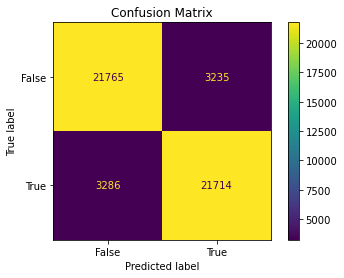

MultinomialNB() CountVectorizer()
Best Model score :  0.89843
Training Accuracy:  0.90066
Test Accuracy    :  0.89810
Model Fit Time   :  2.82619
Best parameters MultinomialNB(): {'vct__max_features': 3000}


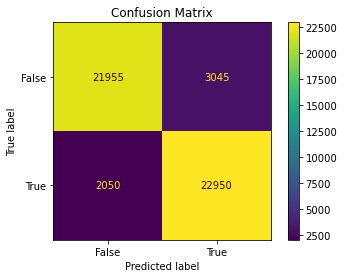

LogisticRegression(max_iter=250) TfidfVectorizer()
Best Model score :  0.91453
Training Accuracy:  0.92136
Test Accuracy    :  0.91418
Model Fit Time   :  4.65419
Best parameters LogisticRegression(max_iter=250): {'vct__max_features': 3000}


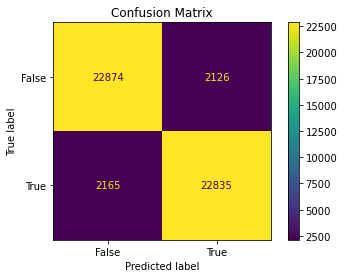

DecisionTreeClassifier() TfidfVectorizer()
Best Model score :  0.85859
Training Accuracy:  0.99999
Test Accuracy    :  0.85894
Model Fit Time   :  69.34328
Best parameters DecisionTreeClassifier(): {'vct__max_features': 3000}


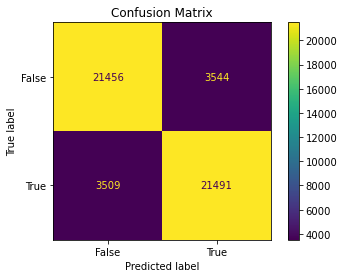

MultinomialNB() TfidfVectorizer()
Best Model score :  0.89381
Training Accuracy:  0.89679
Test Accuracy    :  0.89260
Model Fit Time   :  2.92394
Best parameters MultinomialNB(): {'vct__max_features': 3000}


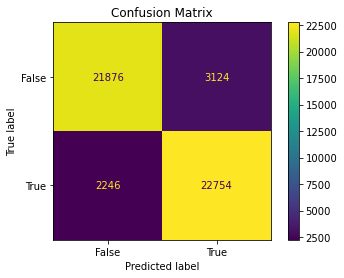

CPU times: user 13min 14s, sys: 2.53 s, total: 13min 16s
Wall time: 13min 17s


model         vectorizer                  best_params  best_score  \
0       Logistic  CountVectorizer()  {'vct__max_features': 3000}    0.918220   
1  Decision Tree  CountVectorizer()  {'vct__max_features': 3000}    0.870147   
2          Bayes  CountVectorizer()  {'vct__max_features': 3000}    0.898433   
3       Logistic  TfidfVectorizer()  {'vct__max_features': 3000}    0.914527   
4  Decision Tree  TfidfVectorizer()  {'vct__max_features': 3000}    0.858593   
5          Bayes  TfidfVectorizer()  {'vct__max_features': 3000}    0.893807   

        time                                                   pipe  \
0   6.195604  (CountVectorizer(), LogisticRegression(max_iter=250))   
1  50.486579          (CountVectorizer(), DecisionTreeClassifier())   
2   2.826186                   (CountVectorizer(), MultinomialNB())   
3   4.654188  (TfidfVectorizer(), LogisticRegression(max_iter=250))   
4  69.343275          (TfidfVectorizer(), DecisionTreeClassifier())   
5   2.923940                   (TfidfVectorizer(), MultinomialNB())   

                                                                                                                                                                                                                                                             grid  \
0  GridSearchCV(estimator=Pipeline(steps=[('vct', CountVectorizer()),\n                                       ('mdl',\n                                        LogisticRegression(max_iter=250))]),\n             param_grid={'vct__max_features': [2000, 3000]})   
1                                                   GridSearchCV(estimator=Pipeline(steps=[('vct', CountVectorizer()),\n                                       ('mdl', DecisionTreeClassifier())]),\n             param_grid={'vct__max_features': [2000, 3000]})   
2                                                            GridSearchCV(estimator=Pipeline(steps=[('vct', CountVectorizer()),\n                                       ('mdl', MultinomialNB())]),\n             param_grid={'vct__max_features': [2000, 3000]})   
3  GridSearchCV(estimator=Pipeline(steps=[('vct', TfidfVectorizer()),\n                                       ('mdl',\n                                        LogisticRegression(max_iter=250))]),\n             param_grid={'vct__max_features': [2000, 3000]})   
4                                                   GridSearchCV(estimator=Pipeline(steps=[('vct', TfidfVectorizer()),\n                                       ('mdl', DecisionTreeClassifier())]),\n             param_grid={'vct__max_features': [2000, 3000]})   
5                                                            GridSearchCV(estimator=Pipeline(steps=[('vct', TfidfVectorizer()),\n                                       ('mdl', MultinomialNB())]),\n             param_grid={'vct__max_features': [2000, 3000]})   

   train_acc  test_acc  \
0   0.926747   0.91794   
1   0.999993   0.86958   
2   0.900660   0.89810   
3   0.921360   0.91418   
4   0.999993   0.85894   
5   0.896787   0.89260   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     cv_results  
0                                        {'mean_fit_time': [2.70160026550293, 2.962960433959961], 'std_fit_time': [0.167489

In [32]:
%%time
# initialize lists
models = ['Logistic', 'Decision Tree', 'Bayes']
all_models = [lgr, dtr, mnb]

# initialize output dataframe
out_results = pd.DataFrame(columns = ['model', 'vectorizer', 'best_params', 'best_score', 'time', 'pipe', 'grid', 
                                     'train_acc', 'test_acc', 'cv_results'])
for v in [cntvct, tfdvct]:
    for m in [lgr, dtr, mnb]:
        pipe, grid, train, test, time, score, best_params, results = model_executor(m, v, params)
        # create an entry in the dataframe
        out_results.loc[len(out_results)] = [models[all_models.index(m)], v, best_params, score, time, pipe, grid,
                                             train, test, results]

# Results
out_results

In [33]:
# # index
# models = ['Logistic', 'Decision Tree', 'Bayes']
# all_models = [lgr, dtr, mnb]
# for m in all_models:
#     print(models[all_models.index(m)])

In [34]:
# out_results = pd.DataFrame(columns = ['model', 'vectorizer', 'best_params', 'best_score'])
# len(out_results)

In [35]:
# decision tree
out_results['cv_results'][1]

{'mean_fit_time': array([24.0967473, 25.8187932]),
 'std_fit_time': array([0.4950773 , 0.98489661]),
 'mean_score_time': array([0.27772145, 0.29331708]),
 'std_score_time': array([0.01322782, 0.01476487]),
 'param_vct__max_features': masked_array(data=[2000, 3000],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'vct__max_features': 2000}, {'vct__max_features': 3000}],
 'split0_test_score': array([0.8674    , 0.87083333]),
 'split1_test_score': array([0.8694, 0.8721]),
 'split2_test_score': array([0.86816667, 0.8697    ]),
 'split3_test_score': array([0.86653333, 0.8702    ]),
 'split4_test_score': array([0.865 , 0.8679]),
 'mean_test_score': array([0.8673    , 0.87014667]),
 'std_test_score': array([0.00148653, 0.00138108]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [36]:
# what is the decision tree depth in grid search
out_results['grid'][1].best_estimator_['mdl'].get_depth()

660

LogisticRegression(max_iter=250) CountVectorizer()
Best Model score :  0.91822
Training Accuracy:  0.92675
Test Accuracy    :  0.91794
Model Fit Time   :  6.21202
Best parameters LogisticRegression(max_iter=250): {'vct__max_features': 3000}


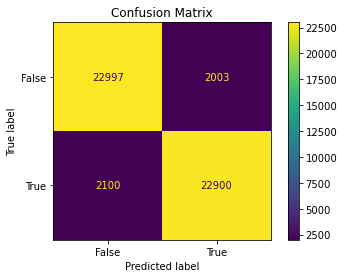

CPU times: user 36.5 s, sys: 304 ms, total: 36.8 s
Wall time: 36.8 s


In [37]:
%%time
lgr_pipe, lgr_grid, lgr_train, lgr_test, lgr_time, lgr_score, lgr_params, lgr_results = model_executor(lgr, cntvct, params)

In [38]:
# Hyperparameters
# Find a sweet spot in max_features:
# Each 1000 results in 1% increment in score, after 2000, each 1000 adds 0.05 to the score
params = {'vct__max_features': [2500],
          'vct__token_pattern':[r"(?u)\b[a-zA-Z]{2,}\b"]}

In [39]:
# LogisticRegression 
lgr_params = {'mdl__C' : [0.8], 'mdl__solver' : ['liblinear'],
              'mdl__penalty' : ['l2'], 'mdl__max_iter' : [250]}
#params = {'penalty': ['l1', 'l2'], 'solver':['liblinear']}
params | lgr_params

{'vct__max_features': [2500],
 'vct__token_pattern': ['(?u)\\b[a-zA-Z]{2,}\\b'],
 'mdl__C': [0.8],
 'mdl__solver': ['liblinear'],
 'mdl__penalty': ['l2'],
 'mdl__max_iter': [250]}

LogisticRegression(max_iter=250) CountVectorizer()
Best Model score :  0.91615
Training Accuracy:  0.92332
Test Accuracy    :  0.91582
Model Fit Time   :  2.46867
Best parameters LogisticRegression(max_iter=250): {'mdl__C': 0.8, 'mdl__max_iter': 250, 'mdl__penalty': 'l2', 'mdl__solver': 'liblinear', 'vct__max_features': 2500, 'vct__token_pattern': '(?u)\\b[a-zA-Z]{2,}\\b'}


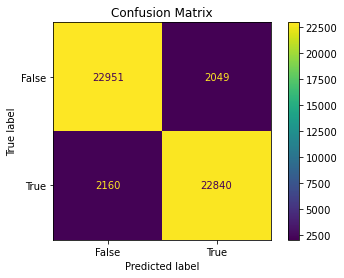

CPU times: user 17.6 s, sys: 145 ms, total: 17.7 s
Wall time: 17.7 s


In [40]:
%%time
# Find sweet spot
'''
Baseline:
lemmitized dataset w/ 3000:
LogisticRegression(max_iter=500) CountVectorizer()
Best Model score :  0.91603
Training Accuracy:  0.92497
Test Accuracy    :  0.91536
Model Fit Time   :  8.16245
'''
lgr_pipe, lgr_grid, lgr_train, lgr_test, lgr_time, lgr_score, lgr_params, lgr_results = \
    model_executor(lgr, cntvct, params | lgr_params)
#lgr_results

LogisticRegression(max_iter=250) TfidfVectorizer()
Best Model score :  0.91230
Training Accuracy:  0.91815
Test Accuracy    :  0.91250
Model Fit Time   :  2.14608
Best parameters LogisticRegression(max_iter=250): {'vct__max_features': 2500, 'vct__token_pattern': '(?u)\\b[a-zA-Z]{2,}\\b'}


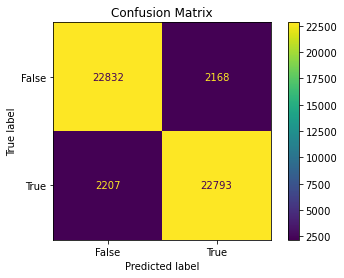

CPU times: user 15.7 s, sys: 157 ms, total: 15.9 s
Wall time: 15.9 s


In [41]:
%%time
# Find sweet spot
'''
stemmed dataset w/ 3000:
LogisticRegression(max_iter=500) CountVectorizer()
Best Model score :  0.91619
Training Accuracy:  0.92513
Test Accuracy    :  0.91538
Model Fit Time   :  8.88952
vs
LogisticRegression(max_iter=500) TfidfVectorizer()
Best Model score :  0.91304
Training Accuracy:  0.91942
Test Accuracy    :  0.91302
Model Fit Time   :  6.45153
'''
lgr_pipe, lgr_grid, lgr_train, lgr_test, lgr_time, lgr_score, lgr_params, lgr_results = model_executor(lgr, tfdvct, params)
#lgr_results

In [42]:
lgr_time*5

10.730412006378174

In [43]:
lgr_pipe.named_steps['mdl']

LogisticRegression(max_iter=250)

In [44]:
lgr_grid

GridSearchCV(estimator=Pipeline(steps=[('vct', TfidfVectorizer()),
                                       ('mdl',
                                        LogisticRegression(max_iter=250))]),
             param_grid={'vct__max_features': [2500],
                         'vct__token_pattern': ['(?u)\\b[a-zA-Z]{2,}\\b']})

In [45]:
lgr_params

{'vct__max_features': 2500, 'vct__token_pattern': '(?u)\\b[a-zA-Z]{2,}\\b'}

# Fine Tune Hyperparameters
Here fine tune model hyperparameters for final results!

## LogisticRegression

In [93]:
# reset hyperparameters
params = {'vct__max_features': [2500],
          'vct__token_pattern':[r"(?u)\b[a-zA-Z]{2,}\b"]}

LogisticRegression(max_iter=250) CountVectorizer()
Best Model score :  0.91615
Training Accuracy:  0.92332
Test Accuracy    :  0.91582
Model Fit Time   :  4.68692
Best parameters LogisticRegression(max_iter=250): {'mdl__C': 0.8, 'mdl__max_iter': 250, 'mdl__penalty': 'l2', 'mdl__solver': 'liblinear', 'vct__max_features': 2500, 'vct__token_pattern': '(?u)\\b[a-zA-Z]{2,}\\b'}


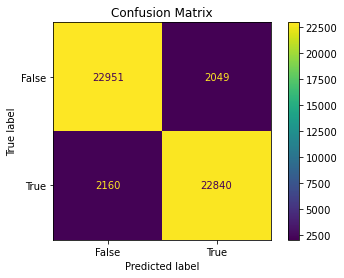

CPU times: user 28.4 s, sys: 245 ms, total: 28.7 s
Wall time: 28.7 s


In [94]:
%%time
# LogisticRegression 
lgr_params = {'mdl__C' : [0.81, 0.8], 'mdl__solver' : ['liblinear'],
              'mdl__penalty' : ['l2'], 'mdl__max_iter' : [250]}

# Find sweet spot
'''
Baseline:
stemmed dataset w/ 3000:
LogisticRegression(max_iter=500) CountVectorizer()
Best Model score :  0.91849
Training Accuracy:  0.92689
Test Accuracy    :  0.91788
Model Fit Time   :  7.28598
Best parameters LogisticRegression(max_iter=500): {'mdl__C': 0.8, 'mdl__max_iter': 250, 'mdl__penalty': 'l2', 'mdl__solver': 'liblinear', 'vct__max_features': 3000, 'vct__token_pattern': '(?u)\\b[a-zA-Z]{2,}\\b'}

'''
lgr_pipe, lgr_grid, lgr_train, lgr_test, lgr_time, lgr_score, lgr_params, lgr_results = \
    model_executor(lgr, cntvct, params | lgr_params)
#lgr_results

## DecisionTreeClassifier

DecisionTreeClassifier() CountVectorizer()
Best Model score :  0.87224
Training Accuracy:  0.91554
Test Accuracy    :  0.87356
Model Fit Time   :  21.80882
Best parameters DecisionTreeClassifier(): {'mdl__criterion': 'entropy', 'mdl__max_depth': 47, 'mdl__min_samples_leaf': 3, 'mdl__min_samples_split': 0.0001, 'vct__max_features': 2500, 'vct__token_pattern': '(?u)\\b[a-zA-Z]{2,}\\b'}


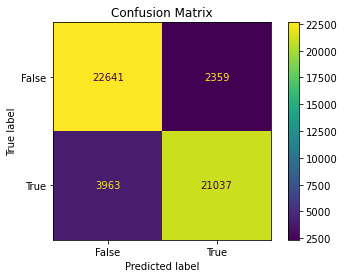

CPU times: user 2min 4s, sys: 361 ms, total: 2min 5s
Wall time: 2min 5s


In [95]:
%%time
# Find sweet spot
'''
Baseline:
stemmed dataset w/ 3000:
DecisionTreeClassifier() CountVectorizer()
Best Model score :  0.87327
Training Accuracy:  0.91405
Test Accuracy    :  0.87288
Model Fit Time   :  41.79231
Best parameters DecisionTreeClassifier(): {'mdl__criterion': 'entropy', 'mdl__max_depth': 47, 'mdl__min_samples_leaf': 3, 'mdl__min_samples_split': 0.0001, 'vct__max_features': 3000, 'vct__token_pattern': '(?u)\\b[a-zA-Z]{2,}\\b'}

'''
# Hyperparameters
dtr_params = {'mdl__max_depth': [45, 47],
              'mdl__min_samples_split': [0.0001],
              'mdl__criterion': ['entropy'],
              'mdl__min_samples_leaf': [3]
             }
# Decision Tree
dtr_pipe, dtr_grid, dtr_train, dtr_test, dtr_time, dtr_score, dtr_params, dtr_results = \
    model_executor(dtr, cntvct, params | dtr_params)
#dtr_results

In [96]:
# what is the decision tree depth in grid search
dtr_grid.best_estimator_

Pipeline(steps=[('vct',
                 CountVectorizer(max_features=2500,
                                 token_pattern='(?u)\\b[a-zA-Z]{2,}\\b')),
                ('mdl',
                 DecisionTreeClassifier(criterion='entropy', max_depth=47,
                                        min_samples_leaf=3,
                                        min_samples_split=0.0001))])

## MultinomialNB

MultinomialNB() CountVectorizer()
Best Model score :  0.89545
Training Accuracy:  0.89731
Test Accuracy    :  0.89528
Model Fit Time   :  2.70639
Best parameters MultinomialNB(): {'mdl__alpha': 0.188, 'mdl__fit_prior': False, 'vct__max_features': 2500, 'vct__token_pattern': '(?u)\\b[a-zA-Z]{2,}\\b'}


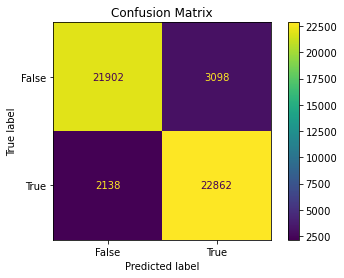

CPU times: user 17.3 s, sys: 246 ms, total: 17.6 s
Wall time: 17.6 s


In [97]:
%%time
# 
# Find sweet spot
'''
Baseline:
MultinomialNB() CountVectorizer()
Best Model score :  0.89835
Training Accuracy:  0.90071
Test Accuracy    :  0.89758
Model Fit Time   :  8.34221
Best parameters MultinomialNB(): {'mdl__alpha': 0.189, 'mdl__fit_prior': False, 'vct__max_features': 3000, 'vct__token_pattern': '(?u)\\b[a-zA-Z]{2,}\\b'}

'''
# Hyperparameters
mnb_params = {'mdl__alpha': [0.188, 0.189],
              'mdl__fit_prior': [False]}
# Decision Tree
mnb_pipe, mnb_grid, mnb_train, mnb_test, mnb_time, mnb_score, mnb_params, mnb_results = \
    model_executor(mnb, cntvct, params | mnb_params)
#mnb_results

# Result Plots
- AUC Results
- Confusion Matrix side-by-side

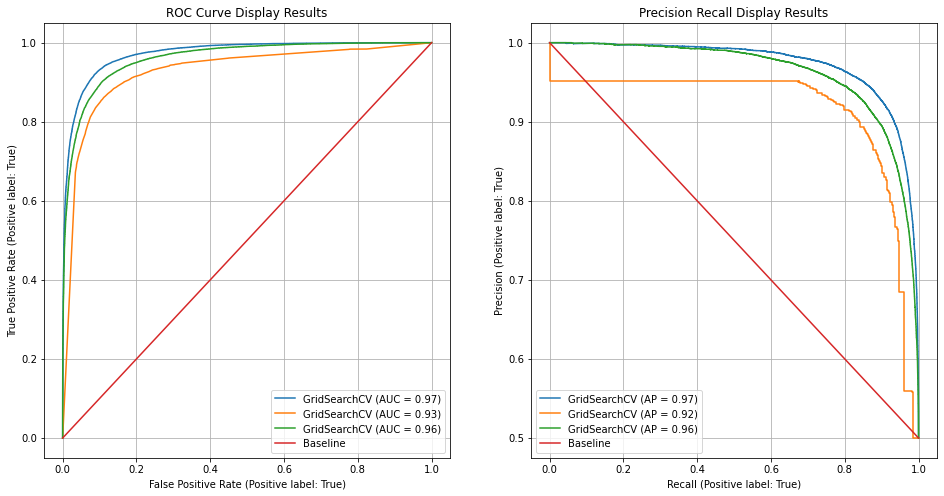

In [98]:
""" Plot ROC Curve 12.6
Get AUC values!
"""
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
#fig, ax = plt.subplots(figsize=(10,8))
# RocCurveDisplay
RocCurveDisplay.from_estimator(lgr_grid, X_test, y_test, pos_label = True, ax = ax[0])
RocCurveDisplay.from_estimator(dtr_grid, X_test, y_test, pos_label = True, ax = ax[0])
RocCurveDisplay.from_estimator(mnb_grid, X_test, y_test, pos_label = True, ax = ax[0])
ax[0].plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'Baseline')
ax[0].set_title('ROC Curve Display Results')
ax[0].grid(True)
ax[0].legend()

# PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(lgr_grid, X_test, y_test, pos_label = True, ax = ax[1])
PrecisionRecallDisplay.from_estimator(dtr_grid, X_test, y_test, pos_label = True, ax = ax[1])
PrecisionRecallDisplay.from_estimator(mnb_grid, X_test, y_test, pos_label = True, ax = ax[1])
ax[1].plot(np.arange(0, 1.2, .2), np.arange(1, 0.4, -.1), label = 'Baseline')
ax[1].set_title('Precision Recall Display Results')
ax[1].grid(True)
ax[1].legend()
plt.show()

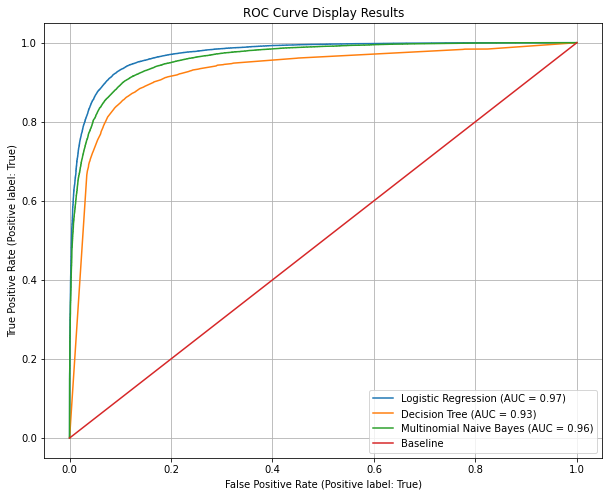

In [101]:
""" Plot ROC Curve 12.6
"""
# RocCurveDisplay
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_estimator(lgr_grid, X_test, y_test, pos_label = True, ax = ax, label = 'Logistic Regression (AUC = 0.97)')
RocCurveDisplay.from_estimator(dtr_grid, X_test, y_test, pos_label = True, ax = ax, label = 'Decision Tree (AUC = 0.93)')
RocCurveDisplay.from_estimator(mnb_grid, X_test, y_test, pos_label = True, ax = ax, label = 'Multinomial Naive Bayes (AUC = 0.96)')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'Baseline')
plt.title('ROC Curve Display Results')
plt.legend()
plt.grid(True)

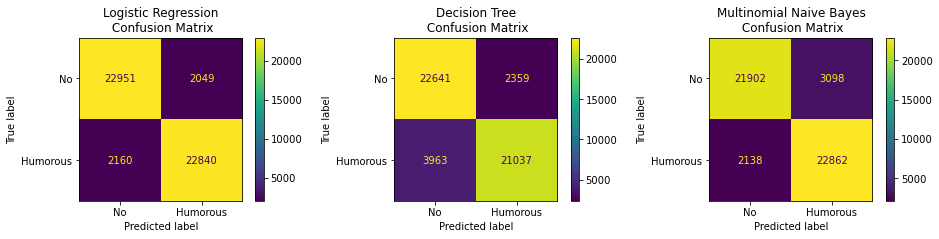

CPU times: user 1.69 s, sys: 20.5 ms, total: 1.71 s
Wall time: 1.71 s


In [102]:
%%time
# plot confusion matrices as summary side-by-side
fig, ax = plt.subplots(1, 3, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, lgr_grid.predict(X_test), display_labels = ['No', 'Humorous'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, dtr_grid.predict(X_test), display_labels = ['No', 'Humorous'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, mnb_grid.predict(X_test), display_labels = ['No', 'Humorous'], ax = ax[2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title('Logistic Regression\n Confusion Matrix')
ax[1].set_title('Decision Tree\n Confusion Matrix')
ax[2].set_title('Multinomial Naive Bayes\n Confusion Matrix')
plt.show()

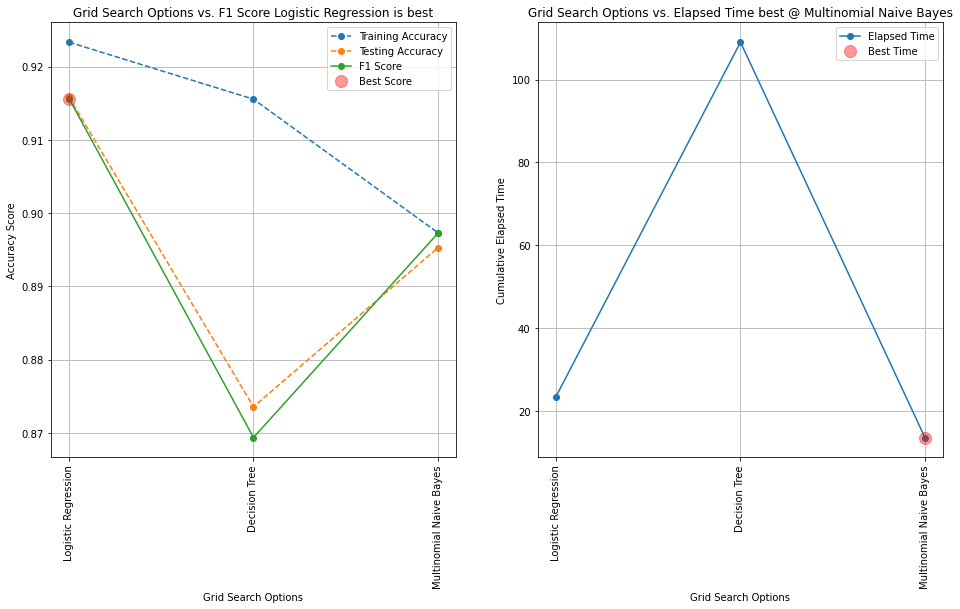

In [103]:
# Time spent
# set metrics (F1)!
grid_options=['Logistic Regression','Decision Tree','Multinomial Naive Bayes']
train_accs = [lgr_train, dtr_train, mnb_train]
test_accs  = [lgr_test, dtr_test, mnb_test]
test_f1s   = [f1_score(y_test, lgr_grid.predict(X_test)),
              f1_score(y_test, dtr_grid.predict(X_test)),
              f1_score(y_test, mnb_grid.predict(X_test))]
elapsed_times = [lgr_time*5, dtr_time*5, mnb_time*5]

# plot accuracy and time elapsed
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(grid_options, train_accs, '--o', label = 'Training Accuracy')
ax[0].plot(grid_options, test_accs, '--o', label = 'Testing Accuracy')
ax[0].plot(grid_options, test_f1s, '-o', label = 'F1 Score')
ax[0].plot(np.argmax(test_f1s), max(test_f1s), 'ro', markersize = 12, alpha = 0.4, label = 'Best Score')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('Grid Search Options')
ax[0].set_ylabel('Accuracy Score')
ax[0].set_title(f'Grid Search Options vs. F1 Score {grid_options[np.argmax(test_f1s)]} is best')
ax[0].legend()
ax[0].grid(True)

# time plot
ax[1].plot(grid_options, elapsed_times, '-o', label = 'Elapsed Time')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xlabel('Grid Search Options')
ax[1].set_ylabel('Cumulative Elapsed Time')
ax[1].set_title(f'Grid Search Options vs. Elapsed Time best @ {grid_options[np.argmin(elapsed_times)]}')
ax[1].plot(np.argmin(elapsed_times), min(elapsed_times), 'ro', markersize = 12, alpha = 0.4, label = 'Best Time')
ax[1].legend()
ax[1].grid(True)

# Test Unseen Samples
These are `humor` samples taken from https://www.rd.com/list/short-jokes/ a few jokes to see how the model performs...

In [104]:
lgr_grid.predict(
    ['What is the best thing about Switzerland? I do not know, but the flag is a big plus.',
    'I invented a new word! Plagiarism!',
    'Did you hear about the mathematician who is afraid of negative numbers? He will stop at nothing to avoid them.',
    'Helvetica and Times New Roman walk into a bar. Get out of here! shouts the bartender. We do not serve your type.',
    'Did you hear about the actor who fell through the floorboards? He was just going through a stage.',
    'Hear about the new restaurant called Karma? There is no menu: You get what you deserve.',
    'Did you hear about the claustrophobic astronaut? He just needed a little space.']
)

array([ True, False,  True,  True,  True,  True,  True])

In [105]:
dtr_grid.predict(
    ['What’s the best thing about Switzerland? I don’t know, but the flag is a big plus.',
    'I invented a new word! Plagiarism!',
    'Did you hear about the mathematician who is afraid of negative numbers? He will stop at nothing to avoid them.',
    'Helvetica and Times New Roman walk into a bar. Get out of here! shouts the bartender. We do not serve your type.',
    'Did you hear about the actor who fell through the floorboards? He was just going through a stage.',
    'Hear about the new restaurant called Karma? There is no menu: You get what you deserve.',
    'Did you hear about the claustrophobic astronaut? He just needed a little space.']
)

array([ True, False,  True,  True,  True,  True,  True])

In [106]:
mnb_grid.predict(
    ['What’s the best thing about Switzerland? I don’t know, but the flag is a big plus.',
    'I invented a new word! Plagiarism!',
    'Did you hear about the mathematician who is afraid of negative numbers? He will stop at nothing to avoid them.',
    'Helvetica and Times New Roman walk into a bar. Get out of here! shouts the bartender. We do not serve your type.',
    'Did you hear about the actor who fell through the floorboards? He was just going through a stage.',
    'Hear about the new restaurant called Karma? There is no menu: You get what you deserve.',
    'Did you hear about the claustrophobic astronaut? He just needed a little space.']
)

array([ True, False,  True,  True,  True,  True,  True])

Ordinary corpus just for negative testing gathered from https://englishgrammarpdf.com/30-examples-of-complex-sentences-in-english-pdf/...

In [107]:
lgr_grid.predict(
    ['Ali wants to attend this meeting but her family issues restrained him.',
    'As soon as Adam leaves the class, I will start reading loud.',
    'Even though we were rich, we drive antique cars.',
    'He cannot come with you, he have to go to office.',
    'He did not want to go to the dentist, though he is very sick.',
    'He has to work hard because he has to feed his 4 children.',
    'Muslims believe that there is no God except one.']
)

array([False,  True, False,  True,  True, False,  True])

In [108]:
dtr_grid.predict(
    ['Ali wants to attend this meeting but her family issues restrained him.',
    'As soon as Adam leaves the class, I will start reading loud.',
    'Even though we were rich, we drive antique cars.',
    'He cannot come with you, he have to go to office.',
    'He did not want to go to the dentist, though he is very sick.',
    'He has to work hard because he has to feed his 4 children.',
    'Muslims believe that there is no God except one.']
)

array([False, False, False, False,  True, False, False])

In [109]:
mnb_grid.predict(
    ['Ali wants to attend this meeting but her family issues restrained him.',
    'As soon as Adam leaves the class, I will start reading loud.',
    'Even though we were rich, we drive antique cars.',
    'He cannot come with you, he have to go to office.',
    'He did not want to go to the dentist, though he is very sick.',
    'He has to work hard because he has to feed his 4 children.',
    'Muslims believe that there is no God except one.']
)

array([False, False,  True,  True,  True,  True,  True])

In [110]:
# %%time
# # initialize lists
# models = ['Logistic', 'Decision Tree', 'Bayes']
# all_models = [lgr, dtr, mnb]

# # initialize output dataframe
# out_results = pd.DataFrame(columns = ['model', 'vectorizer', 'best_params', 'best_score', 'time', 'pipe', 'grid', 
#                                      'train_acc', 'test_acc', 'cv_results'])
# # Execute all 3 models and build result dataframe
# for m in [lgr, dtr, mnb]:
#     # Set model specific search parameters
#     if models[all_models.index(m)] == 'Logistic':
#         # LogisticRegression
#         model_params = {'mdl__C' : [1.0], 'mdl__solver' : ['liblinear'],
#                         'mdl__penalty' : ['l2'], 'mdl__max_iter' : [250]}
#     elif models[all_models.index(m)] == 'Decision Tree':
#         # Decision Tree
#         model_params = {'mdl__C' : [1.1, 1.0], 'mdl__solver' : ['liblinear'],
#                         'mdl__penalty' : ['l2'], 'mdl__max_iter' : [250]}
#     elif models[all_models.index(m)] == 'Bayes':
#         # Bayes
#          model_params = {'mdl__C' : [1.1, 1.0], 'mdl__solver' : ['liblinear'],
#                         'mdl__penalty' : ['l2'], 'mdl__max_iter' : [250]}

#     pipe, grid, train, test, time, score, best_params, results = model_executor(m, cntvct, params)
#     # create an entry in the dataframe
#     out_results.loc[len(out_results)] = [models[all_models.index(m)], cntvct, best_params, score, time, pipe, grid,
#                                          train, test, results]

# # Results
# out_results

In [111]:
# %%time
# # Create Pipeline
# cvect_pipe = Pipeline([
#     ('vct', CountVectorizer()),
#     ('mdl', )
# ]) #.fit(X_train, y_train)

In [112]:
# %%time
# # Grid Search
# grid = GridSearchCV(cvect_pipe, param_grid=params).fit(X_train, y_train)
# grid_acc = grid.score(X_test, y_test)
# print(grid_acc)
# print(grid.best_score_)
# print(grid.best_params_)

In [113]:
# %%time
# model_executor(lgr, tfdvct, params)

In [114]:
# %%time
# model_executor(mnb, tfdvct, params)

In [115]:
# %%time
# model_executor(dtr, tfdvct, params)

In [116]:
[round(i) for i in elapsed_times]

[23, 109, 14]

# Results Dataframe

In [117]:
pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes'], 
             'best_params': [lgr_params, dtr_params, mnb_params],
             'best_score': test_f1s,
             'elapsed_time': [round(i) for i in elapsed_times]}
            ).set_index('model')

best_params  \
model                                                                                                                                                                                                       
Logistic                                 {'mdl__C': 0.8, 'mdl__max_iter': 250, 'mdl__penalty': 'l2', 'mdl__solver': 'liblinear', 'vct__max_features': 2500, 'vct__token_pattern': '(?u)\b[a-zA-Z]{2,}\b'}   
Decision Tree  {'mdl__criterion': 'entropy', 'mdl__max_depth': 47, 'mdl__min_samples_leaf': 3, 'mdl__min_samples_split': 0.0001, 'vct__max_features': 2500, 'vct__token_pattern': '(?u)\b[a-zA-Z]{2,}\b'}   
Bayes                                                                             {'mdl__alpha': 0.188, 'mdl__fit_prior': False, 'vct__max_features': 2500, 'vct__token_pattern': '(?u)\b[a-zA-Z]{2,}\b'}   

               best_score  elapsed_time  
model                                    
Logistic         0.915633            23  
Decision Tree    0.869369           109  
Bayes            0.897253            14

In [82]:
[round(x,1) for x in np.arange(1, -0.1, -.1)]

[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

In [73]:
np.arange(0, 1.1, .1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [79]:
0-.1

-0.1